In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_data = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_data  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)

Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw



Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw


Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



SAMPLE AT INDEX 0
LABEL: 5


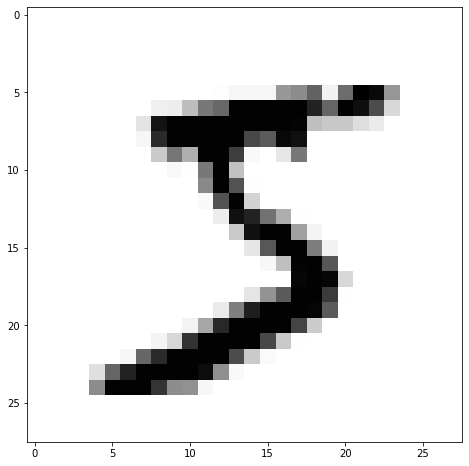

In [3]:
sample_index = 0
image = train_data[sample_index][0]
label = train_data[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

In [4]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

**Useful functions definition**

In [5]:
def calculate_accuracy(predictions, labels, sample_size):
  return (predictions == labels).int().sum().item() / sample_size

In [6]:
def get_prediction(output):
  sig = nn.Sigmoid()
  prediction = torch.argmax(sig(output), dim=1)
  return prediction

In [7]:
def train_model(net, loss_function, optimizer, num_epochs, train_dataloader, val_dataloader, verbose=True):
  print(net)
  train_accuracy_log = []
  val_accuracy_log = []
  train_loss_log = []
  val_loss_log = []
  for epoch_num in range(num_epochs):
    if verbose:
      print('#################')
      print(f'# EPOCH {epoch_num}')
      print('#################')

    ### TRAIN
    train_pred = []
    train_loss = []
    
    net.train() # Training mode (e.g. enable dropout)
    for sample_batched in train_dataloader:
      # Move data to device
      x_train = sample_batched[0].to(device)
      labels_train = sample_batched[1].to(device)
      #print(x_train.shape)
      # Forward pass
      out = net(x_train)
      # Compute loss
      loss = loss_function(out, labels_train)

      # Backpropagation
      net.zero_grad()
      loss.backward()

      # Update the weights
      optimizer.step()

      #Compute predictions
      predictions = get_prediction(out)
      train_predicted = calculate_accuracy(predictions, labels_train, x_train.shape[0])

      # Save train loss for this batch
      train_pred.append(train_predicted)
      loss_batch = loss.detach().cpu().numpy()
      train_loss.append(loss_batch)

    # Save average train loss
    train_pred = np.mean(train_pred)
    train_loss = np.mean(train_loss)
    if verbose:
      print(f"AVERAGE TRAIN ACCURACY: {train_pred * 100}%")
      print(f"AVERAGE TRAIN LOSS: {train_loss}")
    train_accuracy_log.append(train_pred)
    train_loss_log.append(train_loss)

    if val_dataloader != None:
      ### VALIDATION
      val_pred = []
      val_loss = []
      net.eval() # Evaluation mode (e.g. disable dropout)
      with torch.no_grad(): # Disable gradient tracking
        for sample_batched in val_dataloader: #should be validation dataloader
          # Move data to device
          x_val = sample_batched[0].to(device)
          labels_val = sample_batched[1].to(device)

          # Forward pass
          output = net(x_val)

          loss = loss_function(output, labels_val)
          
          #Compute predictions
          prediction = get_prediction(output)
          val_predicted = calculate_accuracy(prediction, labels_val, x_val.shape[0])

          # Save val loss for this batch
          val_pred.append(val_predicted)
          loss_batch = loss.detach().cpu().numpy()
          val_loss.append(loss_batch)


        # Save average validation loss
        val_pred = np.mean(val_pred)
        val_loss = np.mean(val_loss)
        if verbose:
          print(f"AVERAGE VAL ACCURACY: {val_pred * 100}%")
          print(f"AVERAGE VAL LOSS: {val_loss}")
        val_accuracy_log.append(val_pred)
        val_loss_log.append(val_loss)
  if val_dataloader != None:
    print(f"Model's validation accuracy: {val_accuracy_log[-1]}")
    print(f"Model's validation loss: {val_loss_log[-1]}")
  return train_accuracy_log, val_accuracy_log, train_loss_log, val_loss_log

In [8]:
def plot_confusion_matrix(predictions, labels, target_names, normalize=False):

  '''
  ============================
  Internal function definition
  ============================
  '''
  def _confusion_matrix(cm,
                            target_names,
                            title='Confusion matrix',
                            cmap=None,
                            normalize=False):
      import itertools

      accuracy = np.trace(cm) / float(np.sum(cm))
      misclass = 1 - accuracy

      if cmap is None:
          cmap = plt.get_cmap('Blues')

      plt.figure(figsize=(8, 6))
      plt.imshow(cm, interpolation='nearest', cmap=cmap)
      plt.title(title)
      plt.colorbar()

      if target_names is not None:
          tick_marks = np.arange(len(target_names))
          plt.xticks(tick_marks, target_names, rotation=45)
          plt.yticks(tick_marks, target_names)

      if normalize:
          cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


      thresh = cm.max() / 1.5 if normalize else cm.max() / 2
      for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          if normalize:
              plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
          else:
              plt.text(j, i, "{:,}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")


      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
      plt.show()
  '''
  ===================================
  End of internal function definition
  ===================================
  '''

  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(predictions, labels)
  _confusion_matrix(conf_mat, target_names=target_names, normalize=normalize)

**Image dataset defintion**

In [9]:
class ImageDataset(Dataset):

  def __init__(self, dataset, transform=None):
    """
    Args:
        csv_file (string): Path to the csv file.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.transform = transform

    # Get x and y values from each line and append to self.data

    self.data = []
    to_tensor = torchvision.transforms.ToTensor()
    for d in dataset:
      image = d[0]
      label = d[1]
      image = to_tensor(image)
      label = torch.tensor(label).long()
      self.data.append((image, label))

    # Now self.data contains all our dataset.
    # Each element of the list self.data is a tuple: (input, output)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    
    sample = self.data[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [10]:
class ImageToVector():

  def __call__(self, sample):
    image = sample[0]
    image = torch.reshape(image, (-1,))
    return (image, sample[1])

**Device Initialization**

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


# **Feed Forward Network**

**Forward net data definition**

In [12]:
torch.manual_seed(0)
composed_transform = transforms.Compose([ImageToVector()])

from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

train_size = int(len(train_data) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_data))

full_dataset = ImageDataset(train_data, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_data, transform=composed_transform) #Test Dataset

In [13]:
batch_size = 100
test_batch = len(test_dataset)
full_dataloader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

**MODEL DEFINITION**


In [14]:
class ForwardNet(nn.Module):
  def __init__(self, drop = 0.5):
    super().__init__()
    
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 512)
    self.fc3 = nn.Linear(512, 256)
    self.out = nn.Linear(256, 10)

    self.act = nn.ReLU()
    self.drop = nn.Dropout(p = drop)
    
    print('Network Initialized')

  def forward(self, x):
    x = self.act(self.fc1(x))
    x = self.drop(x)
    x = self.act(self.fc2(x))
    x = self.drop(x)
    x = self.act(self.fc3(x))
    x = self.drop(x)
    x = self.act(self.out(x))
    return x

In [15]:
torch.manual_seed(0)

In [16]:
def gridSearch(lrs, epochs, dropouts, train_dataloader, val_dataloader, chooseByAccuracy = False, verbose = True):
  bestRes = None
  bestEp = None
  bestLr = None
  bestDrop = None
  totIter = len(lrs) * len(epochs) * len(dropouts)
  print("\n\nTOTAL ITERATIONS: %d\n\n" %(totIter))
  currentIteration = 1
  for ep in epochs:
    for lr in lrs:
      for drop in dropouts:
        print("Iteration %d/%d\n\n" %(currentIteration, totIter))
        currentIteration += 1
        net = ForwardNet(drop)
        net = net.to(device)
        loss_function = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=lr)
        print("Training with lr: %f epochs: %d dropout: %f" %(lr, ep, drop))
        train_accuracy_log, val_accuracy_log, train_loss_log, val_loss_log = train_model(net, loss_function, optimizer, ep, train_dataloader, val_dataloader, verbose)
        if chooseByAccuracy:
          meanAcc = np.mean(val_accuracy_log)
          if bestRes == None or meanAcc > bestRes:
            bestRes = meanAcc
            bestEp = ep
            bestLr = lr
            bestDrop = drop
            print("BEST VAL ACCURACY %f\n\n" %(bestRes))
        else:
          meanLoss = np.mean(train_loss_log)
          if bestRes == None or meanLoss < bestRes:
            bestRes = meanLoss
            bestEp = ep
            bestLr = lr
            bestDrop = drop
            print("BEST VAL LOSS %f\n\n" %(np.mean(val_accuracy_log)))
  return bestLr, bestEp, bestDrop

In [17]:
lrs = [0.001, 0.005]
epochs = [20, 30]
dropouts = [0.3, 0.5]
bestLr, bestEp, bestDrop = gridSearch(lrs, epochs, dropouts, train_dataloader, val_dataloader, chooseByAccuracy = True, verbose=False)



TOTAL ITERATIONS: 8


Iteration 1/8


Network Initialized
Training with lr: 0.001000 epochs: 20 dropout: 0.300000
ForwardNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (act): ReLU()
  (drop): Dropout(p=0.3, inplace=False)
)
Model's validation accuracy: 0.4841666666666667
Model's validation loss: 1.2233121395111084
[0.4755, 0.47925, 0.48041666666666666, 0.4810833333333333, 0.48141666666666666, 0.47925, 0.48141666666666666, 0.48141666666666666, 0.4811666666666667, 0.48383333333333334, 0.48325, 0.4826666666666667, 0.48325, 0.4831666666666667, 0.4826666666666667, 0.4831666666666667, 0.48133333333333334, 0.48133333333333334, 0.4836666666666667, 0.4841666666666667]
BEST VAL ACCURACY 0.481671


Iteration 2/8


Network Initialized
Training with lr: 0.001000 epochs: 20 dropout: 0.500000
Fo

In [18]:
print("Best parameter found lr: %f epochs: %d dropout: %f" %(bestLr, bestEp, bestDrop))

Best parameter found lr: 0.001000 epochs: 30 dropout: 0.500000


**Model initialization**

In [35]:
torch.manual_seed(0)
net = ForwardNet(bestDrop)
net = net.to(device)

Network Initialized


**Loss definition**

In [36]:
loss_function = nn.CrossEntropyLoss()

**Optimizer definition**

In [37]:
optimizer = optim.Adam(net.parameters(), lr=bestLr)

**Training Loop**

In [38]:
epochs = bestEp
train_accuracy_log, val_accuracy_log, train_loss_log, val_loss_log = train_model(net, loss_function, optimizer, epochs, train_dataloader, val_dataloader, True)

ForwardNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (act): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
)
#################
# EPOCH 0
#################
AVERAGE TRAIN ACCURACY: 73.46666666666667%
AVERAGE TRAIN LOSS: 0.77044677734375
AVERAGE VAL ACCURACY: 84.08333333333333%
AVERAGE VAL LOSS: 0.4304423928260803
#################
# EPOCH 1
#################
AVERAGE TRAIN ACCURACY: 88.69375000000001%
AVERAGE TRAIN LOSS: 0.34575164318084717
AVERAGE VAL ACCURACY: 96.43333333333334%
AVERAGE VAL LOSS: 0.12504272162914276
#################
# EPOCH 2
#################
AVERAGE TRAIN ACCURACY: 94.14791666666666%
AVERAGE TRAIN LOSS: 0.20052233338356018
AVERAGE VAL ACCURACY: 96.65%
AVERAGE VAL LOSS: 0.11640538275241852
#################
# EPOCH 3
#################
AVERAGE TRAIN ACCURACY: 94.73

**ACCURACY PLOT**

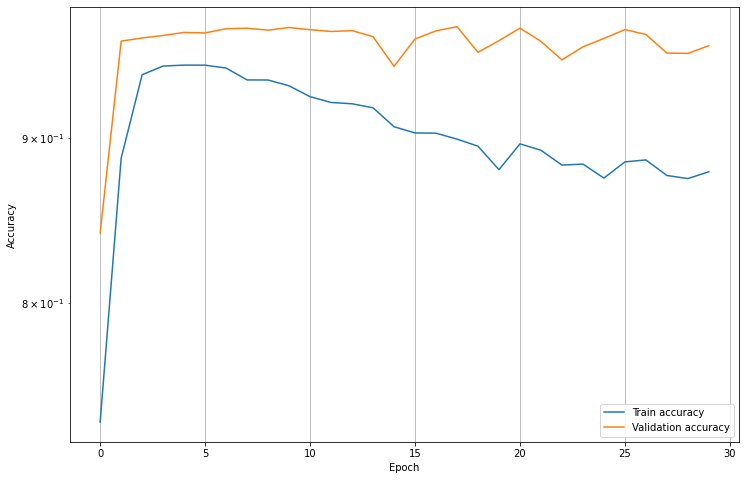

In [39]:
plt.figure(figsize=(12,8))
plt.semilogy(train_accuracy_log, label='Train accuracy')
plt.semilogy(val_accuracy_log, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

**LOSS PLOT**

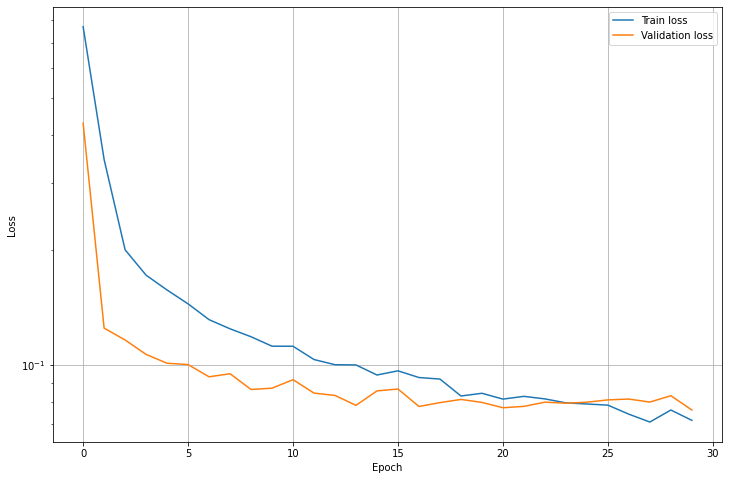

In [40]:
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

**Final model training with the whole training dataset**

The grid search chosen the best model. It's time to train this model found without the validation



In [41]:
#net = ForwardNet(bestDrop)
#net = net.to(device)
#loss_function = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr=bestLr)
#train_accuracy_log, val_accuracy_log, train_loss_log, val_loss_log = train_model(net, loss_function, optimizer, epochs, full_dataloader, None, True)

#print("FINAL MODEL TRAIN ACCURACY: %f" %(np.mean(train_accuracy_log)))
#print("FINAL MODEL TRAIN LOSS: %f" %(np.mean(train_loss_log)))

**Generalization error estimation**

In [42]:
test_predictions = []
sig = nn.Sigmoid()
net.eval()
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader: 
      # Move data to device
      x_test = sample_batched[0].to(device)
     
      #print(total_images)
      labels_test = sample_batched[1].to(device)
      
      # Forward pass
      output = net(x_test)
    
      # Compute prediction
      prediction = get_prediction(output)
      correct_predictions = calculate_accuracy(prediction, labels_test, x_test.shape[0])
      
      # Save val prediction for this batch
      test_predictions.append(correct_predictions)
      
      
    # Save average validation loss
    test_predictions = np.mean(test_predictions)
    print(f"AVERAGE ACCURACY: {test_predictions * 100}%")

AVERAGE ACCURACY: 96.39%


**CONFUSION MATRIX**

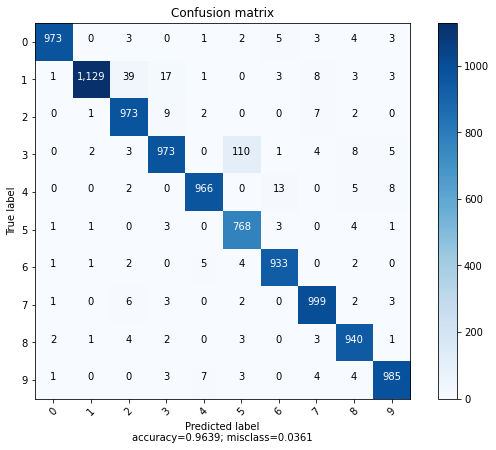

In [43]:
plot_confusion_matrix(prediction.cpu().numpy(), labels_test.cpu().numpy(), target_names=range(10), normalize=False)

In [44]:
fc1 = net.fc1.weight.data.cpu().numpy()
fc2 = net.fc2.weight.data.cpu().numpy()
fc3 = net.fc3.weight.data.cpu().numpy()
out = net.out.weight.data.cpu().numpy()
print(fc1.shape)
print(fc2.shape)
print(fc3.shape)
print(out.shape)

(256, 784)
(512, 256)
(256, 512)
(10, 256)


In [45]:
# Weights histogram
#fig, axs = plt.subplots(4, 1, figsize=(12,8))
#axs[0].hist(fc1, 50)
#axs[0].set_title('First hidden layer weights')
#axs[1].hist(fc2, 50)
#axs[1].set_title('Second hidden layer weights')
#axs[2].hist(fc3, 50)
#axs[2].set_title('Third layer weights')
#axs[3].hist(out, 50)
#axs[3].set_title('Output layer weights')
#[ax.grid() for ax in axs]
#plt.tight_layout()
#plt.show()

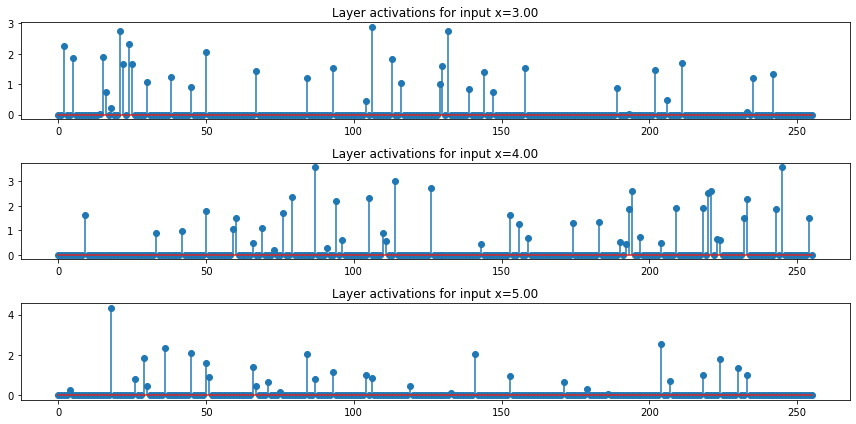

In [46]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)
    

### Register hook  
#We want to inspect the neurons values of the second layer given a specific input in order to show which neuron will fire
hook_handle = net.fc1.register_forward_hook(get_activation) #It's called whenever a forward step is done. 
#When forward phase is completed, hook is called, the activation function used is called and is stored in order to
#vizualize the activated neurons of a specific layer

### Analyze activations
little_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=True, num_workers=0)
for batch in little_dataloader:
  images = batch[0]
  labels = batch[1]
  x1 = images[0]
  label1 = labels[0]
  x1 = x1.unsqueeze(0).to(device)
  x2 = images[1]
  label2 = labels[1]
  x2 = x2.unsqueeze(0).to(device)
  x3 = images[2]
  label3 = labels[2]
  x3 = x3.unsqueeze(0).to(device)
  break
net = net.to(device)
net.eval()
with torch.no_grad():
    
    y1 = net(x1)
    z1 = activation 
    
    y2 = net(x2)
    z2 = activation
    
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))

axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
axs[0].set_title('Layer activations for input x=%.2f' % label1)
axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
axs[1].set_title('Layer activations for input x=%.2f' % label2)
axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
axs[2].set_title('Layer activations for input x=%.2f' % label3)
plt.tight_layout()
plt.show()

In [47]:
def relu(x):
  return np.maximum(0, x)

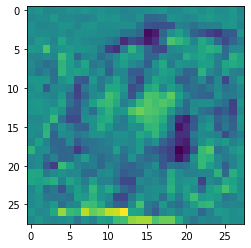

In [48]:
rec_field1 = fc1
#rec_field1 = relu(rec_field1)
image = rec_field1[0].reshape(28, 28)
plt.imshow(image)

(512, 784)


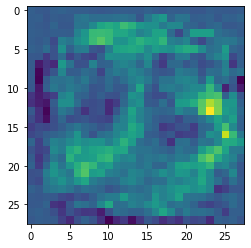

In [49]:
rec_field2 = np.matmul(fc2, rec_field1)
#rec_field2 = relu(rec_field2)
print(rec_field2.shape)
image = rec_field2[72].reshape(28, 28)
plt.imshow(image)

(256, 784)


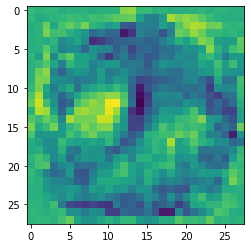

In [50]:
rec_field3 = np.matmul(fc3, rec_field2)
#rec_field3 = relu(rec_field3)
print(rec_field3.shape)
image = rec_field3[25].reshape(28, 28)
plt.imshow(image)

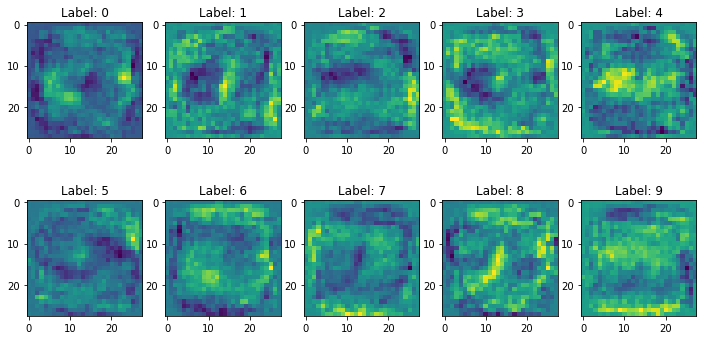

In [51]:
rec_field_out = np.matmul(out, rec_field3)
#rec_field_out = relu(rec_field_out)
fig, axs = plt.subplots(2, 5, figsize=(12,6))
for i in range(5):
  image = rec_field_out[i].reshape(28, 28)
  axs[0][i].imshow(image)
  axs[0][i].set_title("Label: "+str(i))

for i in range(5, 10):
  image = rec_field_out[i].reshape(28, 28)
  axs[1][i - 5].imshow(image)
  axs[1][i - 5].set_title("Label: "+str(i))
#print(rec_field_out.shape)
#for i in range(10):
#  image = rec_field_out[i].reshape(28, 28)
#  print("Label " , i)
#  plt.imshow(image)
#  plt.show()

# Convolutional Network

**Dataset Definition**

In [52]:
torch.manual_seed(0)
composed_transform = None#transforms.Compose([])

train_size = int(len(train_data) * 0.8) #Train-validation 80-20 

train_idxs = range(0, train_size)
val_idxs = range(train_size, len(train_data))

full_dataset = ImageDataset(train_data, transform=composed_transform) #Dataset withouth validation set extracted
train_dataset = torch.utils.data.Subset(full_dataset, train_idxs) #Train dataset
validation_dataset = torch.utils.data.Subset(full_dataset, val_idxs) #Validation Dataset
test_dataset = ImageDataset(test_data, transform=composed_transform) #Test Dataset

In [53]:
batch_size = 100
test_batch = len(test_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=test_batch, shuffle=False, num_workers=0)

**MODEL DEFINITION**

Implemented LeNet5 a state of the art network for digit classification with addition of dropout layers



In [54]:
class DigitNet(nn.Module):
    
    def __init__(self, drop1 = 0.25, drop2 = 0.25, drop3 = 0.7):
        super().__init__()
        
        self.c1 = nn.Conv2d(1, 6, kernel_size=(5, 5), stride=1, padding=2)
        torch.nn.init.kaiming_uniform_(self.c1.weight, nonlinearity='relu')
        self.s2 = nn.AvgPool2d(kernel_size=(2,2), stride = 2)
        self.c3 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=1)
        torch.nn.init.kaiming_uniform_(self.c3.weight, nonlinearity='relu')
        self.s4 = nn.AvgPool2d(kernel_size=(2,2), stride = 2)
        self.c5 = nn.Conv2d(16, 120, kernel_size=(5, 5), stride=1)
        torch.nn.init.kaiming_uniform_(self.c5.weight, nonlinearity='relu')
        self.f6 = nn.Linear(120, 84)
        torch.nn.init.kaiming_uniform_(self.f6.weight, nonlinearity='relu')
        self.out = nn.Linear(84, 10)
        self.act = nn.ReLU()
       
        self.drop1 = nn.Dropout(p = drop1)
        self.drop2 = nn.Dropout(p = drop2)
        self.drop3 = nn.Dropout(p = drop3)
        print('Network initialized')
        
    def forward(self, x):
        x = self.act(self.c1(x)) #conv layer
        x = self.drop1(x) #dropout
        x = self.s2(x) #pooling
        x = self.act(self.c3(x)) #conv
        x = self.drop2(x) #dropout
        x = self.s4(x) #pooling
        x = self.act(self.c5(x)) #conv
        x = x.reshape(x.shape[0], -1)
        x = self.act(self.f6(x)) #flatten
        x = self.drop3(x)
        x = self.out(x) #output
        return x

In [55]:
#loss_function = nn.CrossEntropyLoss()
#hyperparameters = {'lr': [0.001, 0.02], 'weight_decay': [0.0001], 'epochs': [30, 40]}
#grid_search(loss_function, device, 100, 3, full_dataset, hyperparameters)

**Model initialization**

In [56]:
torch.manual_seed(0)
net = DigitNet()
net = net.to(device)

Network initialized


**Loss Definition**

In [57]:
loss_function = nn.CrossEntropyLoss()

**Optimizer Definition**

In [58]:
optimizer = optim.Adam(net.parameters(), lr=0.001)

**Training Loop**

In [59]:
train_accuracy_log, val_accuracy_log, train_loss_log, val_loss_log = train_model(net, loss_function, optimizer, 30, train_dataloader, val_dataloader, True)

DigitNet(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (c5): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (drop3): Dropout(p=0.7, inplace=False)
)
#################
# EPOCH 0
#################
AVERAGE TRAIN ACCURACY: 77.43541666666667%
AVERAGE TRAIN LOSS: 0.705990731716156
AVERAGE VAL ACCURACY: 96.21666666666667%
AVERAGE VAL LOSS: 0.12420646101236343
#################
# EPOCH 1
#################
AVERAGE TRAIN ACCURACY: 93.15%
AVERAGE TRAIN LOSS: 0.2455383688211441
AVERAGE VAL ACCURACY: 97.34166666666667%
AVERAGE VAL LOSS: 0.0900302454829216
#################
# E

**ACCURACY PLOT**

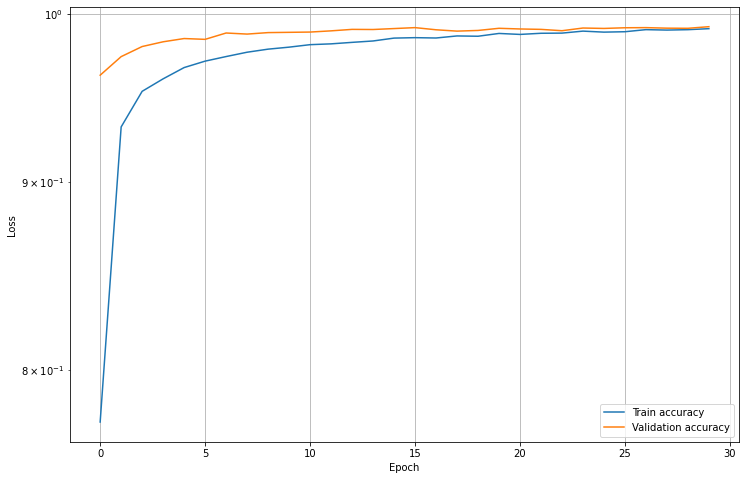

In [60]:
plt.figure(figsize=(12,8))
plt.semilogy(train_accuracy_log, label='Train accuracy')
plt.semilogy(val_accuracy_log, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

**LOSS PLOT**

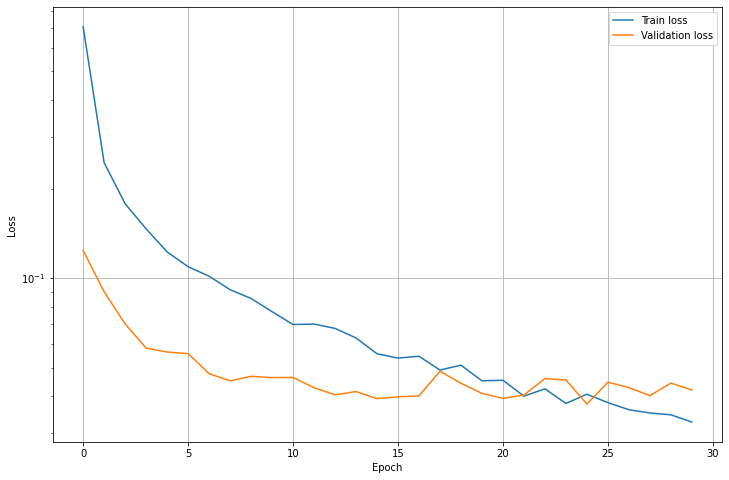

In [61]:
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_log, label='Train loss')
plt.semilogy(val_loss_log, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

**Generalization error estimation**

In [62]:
test_predictions = []
sig = nn.Sigmoid()
net.eval()
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in test_dataloader: 
      # Move data to device
      x_test = sample_batched[0].to(device)
     
      #print(total_images)
      labels_test = sample_batched[1].to(device)
      
      # Forward pass
      output = net(x_test)
    
      # Compute prediction
      prediction = get_prediction(output)
      correct_predictions = calculate_accuracy(prediction, labels_test, x_test.shape[0])
      
      # Save val prediction for this batch
      test_predictions.append(correct_predictions)
      
      
    # Save average validation loss
    test_predictions = np.mean(test_predictions)
    print(f"AVERAGE ACCURACY: {test_predictions * 100}%")

AVERAGE ACCURACY: 99.16%


**CONFUSION MATRIX**

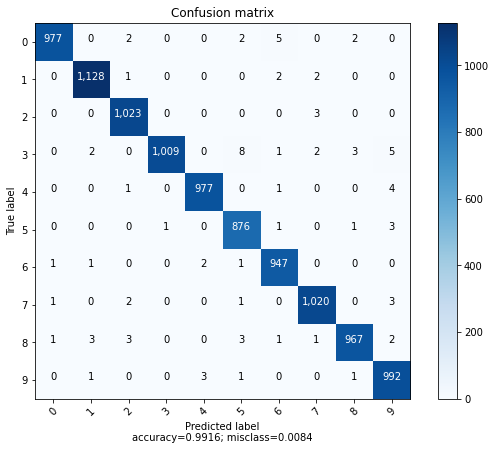

In [63]:
plot_confusion_matrix(prediction.cpu().numpy(), labels_test.cpu().numpy(), target_names=range(10), normalize=False)

**WEIGHTS ANALYSIS**

In [64]:
# First hidden layer
c1_w = net.c1.weight.data.cpu().numpy()
c1_b = net.c1.bias.data.cpu().numpy()
print(c1_w.shape)
# Second hidden layer
c3_w = net.c3.weight.data.cpu().numpy()
c3_b = net.c3.bias.data.cpu().numpy()
print(c3_w.shape)

c5_w = net.c5.weight.data.cpu().numpy()
c5_b = net.c5.bias.data.cpu().numpy()
print(c5_w.shape)

f6_w = net.f6.weight.data.cpu().numpy()
f6_b = net.f6.bias.data.cpu().numpy()
print(f6_w.shape)

# Output layer
out_w = net.out.weight.data.cpu().numpy()
out_b = net.out.bias.data.cpu().numpy()
print(out_w.shape)

(6, 1, 5, 5)
(16, 6, 5, 5)
(120, 16, 5, 5)
(84, 120)
(10, 84)


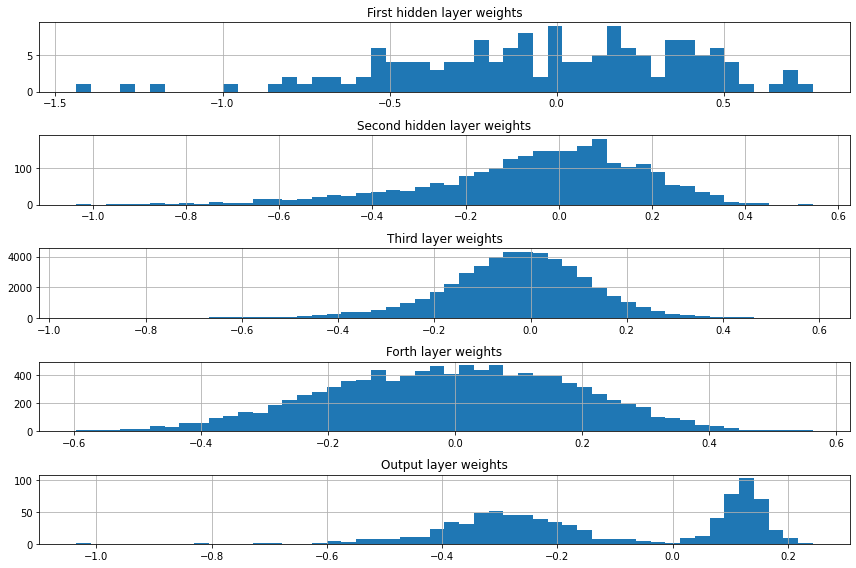

In [65]:
# Weights histogram
fig, axs = plt.subplots(5, 1, figsize=(12,8))
axs[0].hist(c1_w.flatten(), 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(c3_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(c5_w.flatten(), 50)
axs[2].set_title('Third layer weights')
axs[3].hist(f6_w.flatten(), 50)
axs[3].set_title('Forth layer weights')
axs[4].hist(out_w.flatten(), 50)
axs[4].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

In [66]:
net_state_dict = net.state_dict()
# Save the state dict to a file
#the best model is saved in net_parameters.torch
torch.save(net_state_dict, 'net_parameters_test.torch')

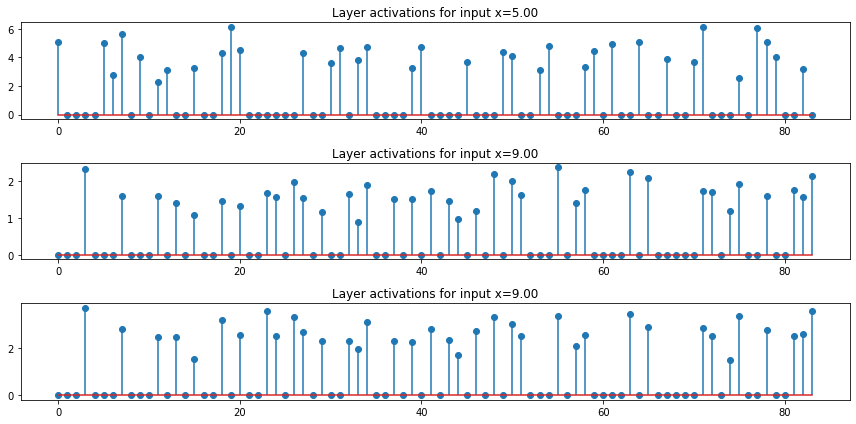

In [67]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)
    

### Register hook  
#We want to inspect the neurons values of the second layer given a specific input in order to show which neuron will fire
hook_handle = net.f6.register_forward_hook(get_activation) #It's called whenever a forward step is done. 
#When forward phase is completed, hook is called, the activation function used is called and is stored in order to
#vizualize the activated neurons of a specific layer

### Analyze activations
little_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=True, num_workers=0)
for batch in little_dataloader:
  images = batch[0]
  
  labels = batch[1]
  x1 = images[0]
  label1 = labels[0]
  x1 = x1.unsqueeze(0).to(device)
  x2 = images[1]
  label2 = labels[1]
  x2 = x2.unsqueeze(0).to(device)
  x3 = images[2]
  label3 = labels[2]
  x3 = x3.unsqueeze(0).to(device)
  break
net = net.to(device)
net.eval()
with torch.no_grad():
    
    y1 = net(x1)
    z1 = activation 
    
    y2 = net(x2)
    z2 = activation
    
    y3 = net(x3)
    z3 = activation

### Remove hook
hook_handle.remove()
### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,6))

axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
axs[0].set_title('Layer activations for input x=%.2f' % label1)
axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
axs[1].set_title('Layer activations for input x=%.2f' % label2)
axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
axs[2].set_title('Layer activations for input x=%.2f' % label3)
plt.tight_layout()
plt.show()

**Kernels**

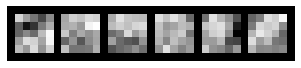

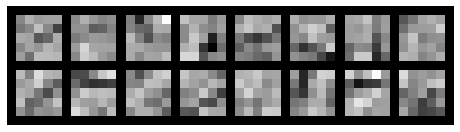

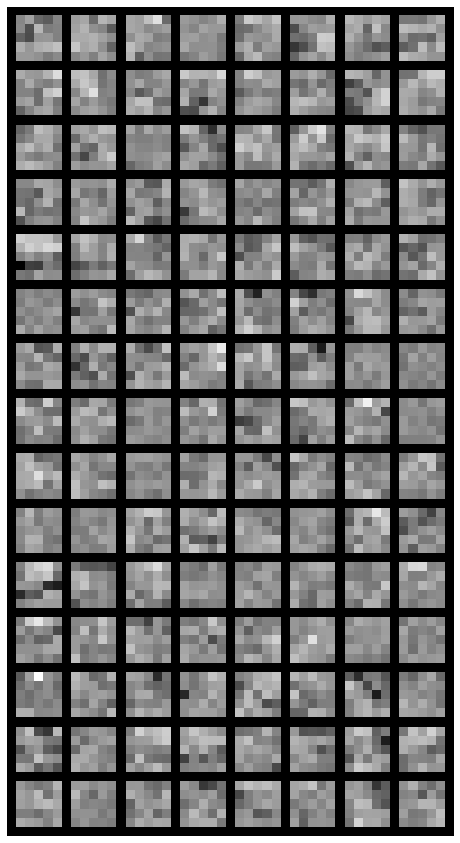

In [68]:


def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape
        #tensor *= 255
        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.axis('off')
        plt.ioff()
        plt.show()


#filter_img = torchvision.utils.make_grid(kernels)
#print(filter_img.shape)

#plt.imshow(filter_img.permute(1, 2, 0))

visTensor(net.c1.weight.detach().cpu(), ch=0, allkernels=False)

visTensor(net.c3.weight.detach().cpu(), ch=0, allkernels=False)

visTensor(net.c5.weight.detach().cpu(), ch=0, allkernels=False)


**Feature maps**

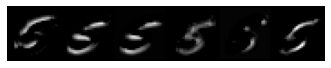

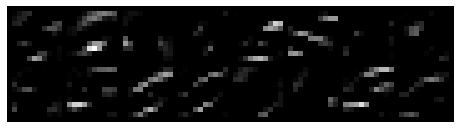

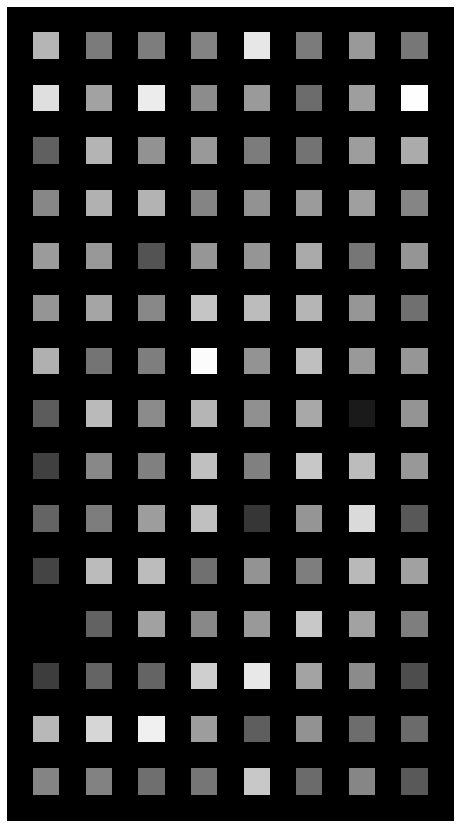

torch.Size([1, 120, 1, 1])


In [69]:
act = nn.ReLU()
c1 = net.c1.to(device)
images1 = c1(x1)
images1 = act(images1)
images1cpu = images1.detach().cpu()
visTensor(images1cpu, ch=0, allkernels=True)

s2 = net.s2.to(device)
c3 = net.c3.to(device)
images2 = s2(images1)
images2 = c3(images2)
images2 = act(images2)
images2cpu = images2.detach().cpu()

visTensor(images2cpu, ch=0, allkernels=True)


s4 = net.s4.to(device)
c5 = net.c5.to(device)
images3 = c5(s4(images2))
images3cpu = images3.detach().cpu()
visTensor(images3cpu, ch=0, allkernels=True)
print(images3.shape)



In [70]:
def visualize_receptive_field(image):
  input = torch.ones_like(image, requires_grad=True)
  out = net(input)
  sig = nn.Sigmoid()
    
  prediction = torch.argmax(sig(net(image)), dim=1) #prediction of the true image
  #print(sig(out))

  grad = torch.zeros_like(out, requires_grad=True)
  grad[0][prediction] = 1
  #print(grad)

  out.backward(gradient=grad)
  gradient_of_input = input.grad[0, 0].data.cpu().numpy()
  gradient_of_input = gradient_of_input / np.amax(gradient_of_input)

  def normalize(activations):
      # transform activations so that all the values be in range [0, 1]
      activations = activations - np.min(activations[:])
      activations = activations / np.max(activations[:])
      return activations


  def visualize_activations(image, activations):
      activations = normalize(activations)

      # replicate the activations to go from 1 channel to 3
      # as we have colorful input image
      # we could use cvtColor with GRAY2BGR flag here, but it is not
      # safe - our values are floats, but cvtColor expects 8-bit or
      # 16-bit inttegers
      masked_image = (image * activations)
        
      return masked_image


  receptive_field_mask = visualize_activations(image.cpu().numpy(), gradient_of_input)
  return receptive_field_mask[0][0]
  #plt.imshow(receptive_field_mask[0][0], cmap='Greys')
  #plt.show()
    


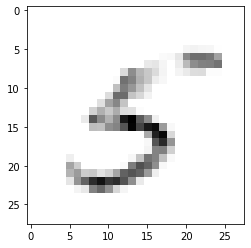

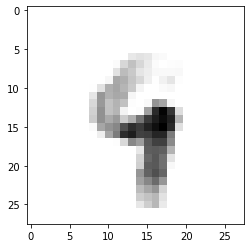

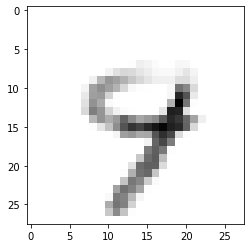

In [71]:
rec1 = visualize_receptive_field(x1)
plt.imshow(rec1, cmap='Greys')
plt.show()

rec2 = visualize_receptive_field(x2)
plt.imshow(rec2, cmap='Greys')
plt.show()

rec3 = visualize_receptive_field(x3)
plt.imshow(rec3, cmap='Greys')
plt.show()